# Workshop Questions:
In this workshop we will investigate the bistable toggle model provided below. The goal is to find cases where the model does not behave as expected when simulated stochastically or as part of a cell lineage.

## Question 1: Stochastics
Using a SimpleTxTlDilutionMixture, find initial conditions and/or parameters such that the ToggleSwitch occasionally transition between its two states. Compare this to what happens when the ToggleSwitch is simulated deterministically using these same parameters

## Question 2: Lineages
Using a SimpleTxTlExtractMixture loaded from SBML into Bioscrape Lineages, find parameters or initial conditions such that the Bistable Toggle exhibits bistability in a population of cells. This means that a cell (and its offspring) tend to stay in the same state they start in.

In [7]:
from biocrnpyler import *
#Create Repressors
LacI = Species("lacI")
tetR = Species("tetR")
#Create Repressable Promoters
pLac = RepressablePromotor("pLac", transcript = "tetR", repressor = LacI)
pTEt = RepressablePromotor("pTet", transcript = "lacI", repressor = tetR)
#Create DNAassemblies
placI_tetR = DNAassembly(name = "lacI_tetR", promoter = pLac, rbs = "BCD8", protein = tetR)
ptetR_lacI = DNAassembly(name = "tetR_lacI", promoter = pTEt, rbs = "BCD8", protein = LacI)


parameters = {("negativehill_transcription", "k"):0.01875,
              ("negativehill_transcription", "K"):20,
              ("negativehill_transcription", "n"):2.0, #This parameter must remain greater than or equal to 2!
              ("negativehill_transcription", "kleak"):.00001,
              ("simple_translation", "ktl"):.5, 
              ("kdil"):.001} 
#If investigating stochastics use SimpleTxTlDilutionMixture
ToggleSwitch = SimpleTxTlDilutionMixture(name = "stochastic crn", components = [placI_tetR, ptetR_lacI], parameters = parameters)

#If investigting Lineages use SimpleTxTlDilutionMixture
#ToggleSwitch = SimpleTxTlExtract(name = "lineage CRN", components = [placI_tetR, ptetR_lacI], parameters = parameters)

ToggleCRN = ToggleSwitch.compile_crn() #; print(ToggleCRN.pretty_print())

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/biocrnpyler-0.2.1-py3.7.egg/biocrnpyler/chemical_reaction_network.py:888: UserWarning: Reaction tetR -->         massaction: k_f(tetR)=0.001*tetR may be duplicated in CRN definitions. Duplicates have NOT been removed.
/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/biocrnpyler-0.2.1-py3.7.egg/biocrnpyler/chemical_reaction_network.py:888: UserWarning: Reaction rna_lacI_tetR -->         massaction: k_f(rna_lacI_tetR)=0.001*rna_lacI_tetR may be duplicated in CRN definitions. Duplicates have NOT been removed.
/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/biocrnpyler-0.2.1-py3.7.egg/biocrnpyler/chemical_reaction_network.py:888: UserWarning: Reaction lacI -->         massaction: k_f(lacI)=0.001*lacI may be duplicated in CRN definitions. Duplicates have NOT been removed.
/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/biocrnpyler-0.2.1-py3.7.egg/biocrnpyler/chemica

In [32]:
print(ToggleCRN.pretty_print())

Species (6) = {0. tetR, 1. rna[lacI_tetR], 2. lacI, 3. dna[lacI_tetR], 4. rna[tetR_lacI], 5. dna[tetR_lacI]}
Reactions (14) = [
0. dna[lacI_tetR] --> dna[lacI_tetR] + rna[lacI_tetR]        
        proportionalhillnegative: k(lacI, dna[lacI_tetR])=0.01875*dna[lacI_tetR]/(20+lacI^2.0)
1. dna[lacI_tetR] --> dna[lacI_tetR] + rna[lacI_tetR]        
        massaction: k_f(dna[lacI_tetR])=1e-05*dna[lacI_tetR]
2. rna[lacI_tetR] --> rna[lacI_tetR] + tetR        
        massaction: k_f(rna[lacI_tetR])=0.5*rna[lacI_tetR]
3. dna[tetR_lacI] --> dna[tetR_lacI] + rna[tetR_lacI]        
        proportionalhillnegative: k(tetR, dna[tetR_lacI])=0.01875*dna[tetR_lacI]/(20+tetR^2.0)
4. dna[tetR_lacI] --> dna[tetR_lacI] + rna[tetR_lacI]        
        massaction: k_f(dna[tetR_lacI])=1e-05*dna[tetR_lacI]
5. rna[tetR_lacI] --> rna[tetR_lacI] + lacI        
        massaction: k_f(rna[tetR_lacI])=0.5*rna[tetR_lacI]
6. tetR -->         
        massaction: k_f(tetR)=0.001*tetR
7. rna[lacI_tetR] -->       

In [10]:
ToggleCRN.write_sbml_file('ToggleCRN.xml')

True

In [33]:
x0 = {
    str(tetR):200,
    'dna[lacI_tetR]':200,
    'dna[tetR_lacI]':200,
    'lacI':200,
    
}
timepoints = np.linspace(0, 30, 100)

In [51]:
from bioscrape.lineage import LineageModel, LineageVolumeSplitter, py_SimulateSingleCell
M = LineageModel(initial_condition_dict = x0, sbml_filename = "ToggleCRN.xml")

vsplit_options = {
    "default":"binomial",
    str(LacI):"duplicate",
    str(tetR):"duplicate",
    #str(G1P):"duplicate"
}

vsplit = LineageVolumeSplitter(M, options = vsplit_options)


delta = 1
M.create_division_rule("deltaV", {"threshold":delta}, vsplit)
g = .1
kgrow = .012
M.create_volume_event("linear volume", {"growth_rate":g}, "massaction", {"k":kgrow, "species":str(tetR)})

M.py_initialize()


# division, volume 
# initialize

In [56]:
R = py_SimulateSingleCell(timepoints, Model = M)
R.head()

,tetR,rna_lacI_tetR,lacI,dna_lacI_tetR,rna_tetR_lacI,dna_tetR_lacI,dna[lacI_tetR],dna[tetR_lacI],time,volume
0,200.0,0.0,200.0,0.0,0.0,0.0,200.0,200.0,0.00000,1.0
1,200.0,0.0,200.0,0.0,0.0,0.0,200.0,200.0,0.03003,1.1
2,200.0,0.0,200.0,0.0,0.0,0.0,200.0,200.0,0.06006,1.1
3,200.0,0.0,200.0,0.0,0.0,0.0,200.0,200.0,0.09009,1.1
4,200.0,0.0,200.0,0.0,0.0,0.0,200.0,200.0,0.12012,1.1


Text(0.5, 1.0, 'A Single Cell')

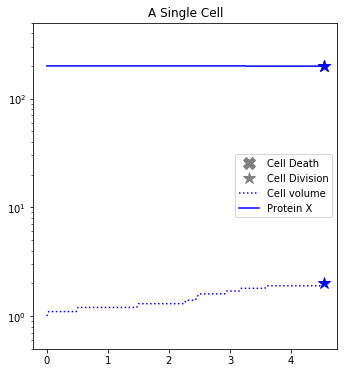

In [60]:
#plotting
tmax = 30
timepoints = np.linspace(0, tmax, 1000)
ymin = .5
ymax = 500
ms = 12

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(0, 0, "X", ms = ms, color = "grey", label = "Cell Death")
plt.plot(0, 0, "*", ms = ms, color = "grey", label = "Cell Division")
plt.plot(R["time"], R["volume"], ":", label = "Cell volume", color = (0, 0, 1))
plt.plot(R["time"], R[str(tetR)], label = "Protein X", color = (0, 0, 1))

plt.plot(R["time"][len(R["time"])-1], R["tetR"][len(R["tetR"])-1], "*", ms = ms, color = (0, 0, 1))
plt.plot(R["time"][len(R["time"])-1], R["tetR"][len(R["lacI"])-1], "*", ms = ms, color = (0, 0, 1))


plt.plot(R["time"][len(R["time"])-1], R["volume"][len(R["volume"])-1], "*", ms = ms, color = (0, 0, 1))

plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("A Single Cell")

# plt.subplot(122)
# plt.title("Other Species in the Model")
# plt.plot(R["time"], R['lacI']+R[str(F1)]+R[str(G1)]+R[str(G1P)], label = "Total S")
# plt.plot(R["time"], R[str(F0)]+R[str(F1)]+R[str(G1)]+R[str(G1P)], label = "F")
# plt.plot(R["time"], R[str(P)]+R[str(G1P)], label = "Total P")
# plt.plot(R["time"], R[str(Ri)]+R[str(TR)], label = "Total R")
# plt.plot(R["time"], R[str(T)]+R[str(TR)], label = "Total T")
# plt.legend()



Simulate a lineage

Text(0.5, 1.0, 'Non-interacting Cells')

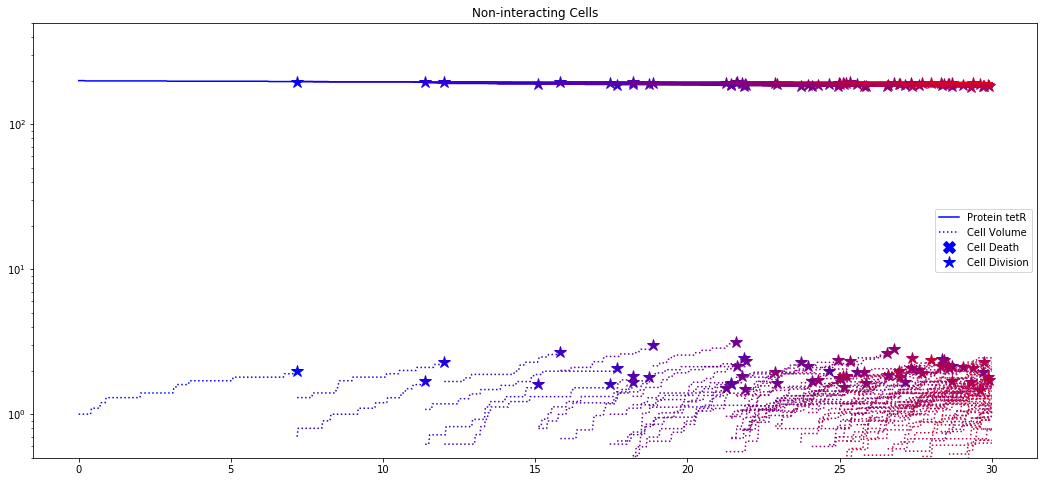

In [69]:
#Simulate a Non-interacting Lineage
from bioscrape.lineage import py_SimulateCellLineage

lineage = py_SimulateCellLineage(timepoints, Model = M)
sch_tree = lineage.get_schnitzes_by_generation()
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

#Plotting
plt.figure(figsize = (18, 8))
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch_ind in range(len(L)):
        sch = L[sch_ind]
    
        df = sch.py_get_dataframe(Model = M)
        
        
        if sch_ind == 0 and generation == 0:
            plt.plot(df["time"], df["tetR"], color = color_list[generation], label = "Protein tetR")
            plt.plot(df["time"], df["volume"], ":", color = color_list[generation], label = "Cell Volume")
        else:
            plt.plot(df["time"], df["tetR"], color = color_list[generation])
            plt.plot(df["time"], df["volume"], ":", color = color_list[generation])
        
        dead = sch.py_get_daughters()[0] is None and df["time"][len(df["time"])-1] < timepoints[-1]
        divided = sch.py_get_daughters()[0] is not None and df["time"][len(df["time"])-1] < timepoints[-1]
        
        if dead:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "X", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["tetR"][len(df["tetR"])-1], "X", ms = ms, color = color_list[generation])
        if divided:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "*", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["tetR"][len(df["tetR"])-1], "*", ms = ms, color = color_list[generation])

plt.plot(0, 0, "X", ms = ms, color = color_list[0], label = "Cell Death")
plt.plot(0, 0, "*", ms = ms, color = color_list[0], label = "Cell Division")
plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("Non-interacting Cells")



/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following species are uninitialized and their value has been defaulted to 0: tetR, 
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Cells Exchanging X with Each Other and the Enviornment')

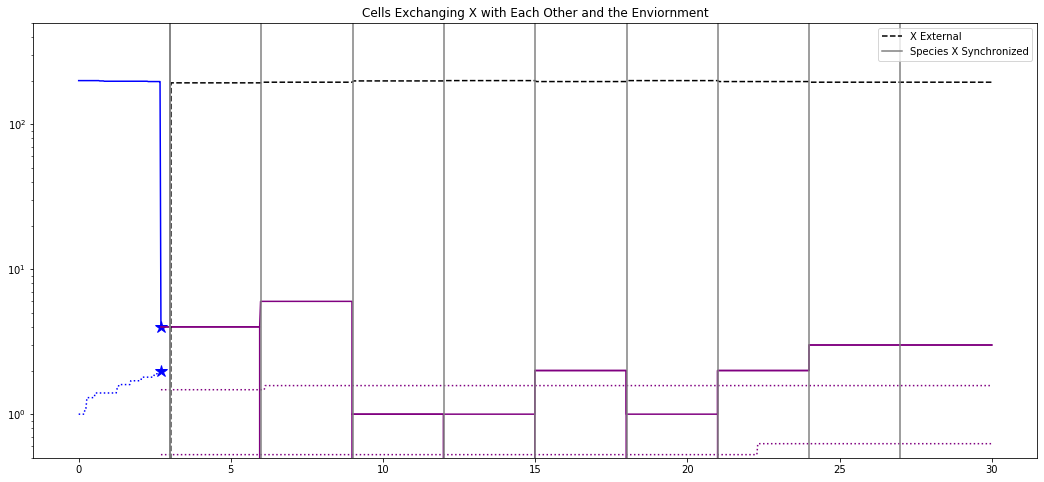

In [66]:
from bioscrape.lineage import py_SimulateInteractingCellLineage
from bioscrape.types import Model

global_sync_period = 3
global_volume = 150
average_dist_threshold = 5
initial_cell_counts = [1]

global_species = ['tetR']
#Could load another SBML Model for the Environment!
global_crn = Model(species = global_species)

lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, 
                                                                            global_volume = global_volume, 
                                                                            model_list = [M],
                                                                            initial_cell_states = initial_cell_counts,
                                                                            global_species = global_species,
                                                                            global_volume_model = global_crn,
                                                                            average_dist_threshold = average_dist_threshold)

lineage_interacting = lineage_list[0]
sch_tree = lineage_interacting.get_schnitzes_by_generation()
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

plt.figure(figsize = (18, 8))
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch_ind in range(len(L)):
        sch = L[sch_ind]
    
        df = sch.py_get_dataframe(Model = M)
        plt.plot(df["time"], df["volume"], ":", color = color_list[generation])
        
        plt.plot(df["time"], df['tetR'], color = color_list[generation])
        
        dead = sch.py_get_daughters()[0] is None and df["time"][len(df["time"])-1] < timepoints[-1]
        divided = sch.py_get_daughters()[0] is not None and df["time"][len(df["time"])-1] < timepoints[-1]
        
        if dead:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "X", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df['tetR'][len(df['tetR'])-1], "X", ms = ms, color = color_list[generation])
        if divided:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "*", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df['tetR'][len(df['tetR'])-1], "*", ms = ms, color = color_list[generation])

df_global = global_results.py_get_dataframe(Model = global_crn)
plt.plot(df_global["time"], df_global['tetR'], "--", label = "X External", color = "black")

for i in range(global_sync_period, tmax, global_sync_period):
    if i == global_sync_period:
        plt.plot([i, i], [ymin, ymax], color = "grey", label = "Species X Synchronized")
    plt.plot([i, i], [ymin, ymax], color = "grey")

plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("Cells Exchanging X with Each Other and the Enviornment")

In [53]:
R.head()

,tetR,rna_lacI_tetR,lacI,dna_lacI_tetR,rna_tetR_lacI,dna_tetR_lacI,dna[lacI_tetR],dna[tetR_lacI],time,volume
0,200.0,0.0,200.0,0.0,0.0,0.0,200.0,200.0,0.000000,1.0
1,200.0,0.0,200.0,0.0,0.0,0.0,200.0,200.0,0.303030,1.0
2,200.0,0.0,200.0,0.0,0.0,0.0,200.0,200.0,0.606061,1.2
3,200.0,0.0,200.0,0.0,0.0,0.0,200.0,200.0,0.909091,1.3
4,200.0,0.0,199.0,0.0,0.0,0.0,200.0,200.0,1.212121,1.3


In [44]:
R.columns

Index(['tetR', 'rna_lacI_tetR', 'lacI', 'dna_lacI_tetR', 'rna_tetR_lacI',
       'dna_tetR_lacI', 'dna[lacI_tetR]', 'dna[tetR_lacI]', 'time', 'volume'],
      dtype='object')

In [38]:
import bokeh.io
import bokeh.plotting.figure
import colorcet
bokeh.io.output_notebook()

Loading BokehJS ...

In [45]:
p = bokeh.plotting.figure(width = 550, height = 450)
palette = colorcet.b_glasbey_category10
plot_list = []
for i, label in enumerate(R.columns):
    if label == 'time':
        None
    else:
        p.circle(timepoints, R[label], color = palette[i], legend_label = label)
p.legend.click_policy = 'hide'
bokeh.io.show(p)

### Helpful Code Below for Question 1

The below code cylces through different initial conditions and plots trajectories to show the Bistability of the toggle switch. The goal is to find parameter values where stochastic switching between the two states occasionally occurs - namely that lines starting near all the blue dots ends up near the red X or visa-versa.

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Text(0.5, 1.0, 'Bistable Toggle Phase Space')

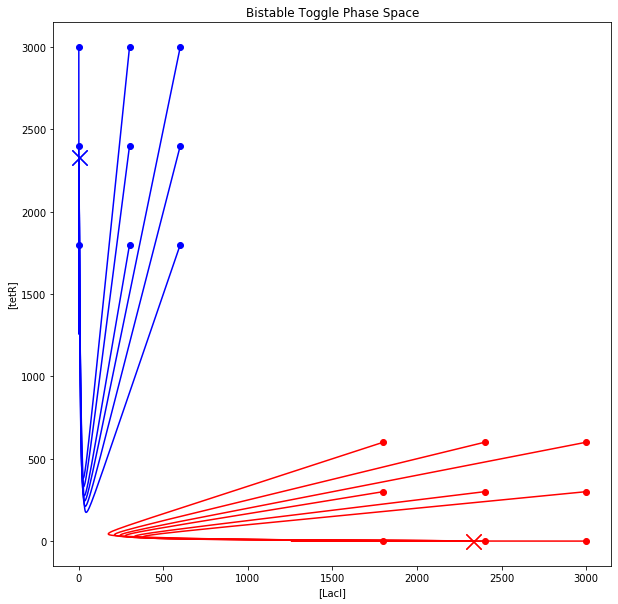

In [2]:
import pylab as plt
import numpy as np

#Toggle between deterministic and stochastic simulation
stochastic = False

#Set initial concentrations
placI0 = 1.0
ptetR0 = 1.0
x0_dict = {repr(placI_tetR.get_species()):placI0, repr(ptetR_lacI.get_species()):ptetR0}

#Simulation time might have to change as well
timepoints = np.linspace(0, 10000, 1000)
fixed_point = 2400 #Approximate value of the fixed point for either tetR or LacI

plt.figure(figsize = (10, 10))

#Generate a bunch of points around each fixed point
for v1 in np.linspace(.75*fixed_point, 1.25*fixed_point, 3): #this generates points near fixed_point
    for v2 in np.linspace(0, .25*fixed_point, 3): #this generates points near 0
        
        #Simulate around tetR fixed point
        x0_dict[repr(LacI)] = int(v2)
        x0_dict[repr(tetR)] = int(v1)
        R = ToggleCRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)
        plt.plot(R[str(LacI)], R[str(tetR)], color = "blue")
        plt.plot(int(v2), int(v1), 'o', color = "blue")
        plt.plot(R[str(LacI)][len(timepoints)-1], R[str(tetR)][len(timepoints)-1], 'x', alpha = .5, color = "blue", ms = 15)
        
        
        #Simulate around lacI fixued point
        x0_dict[repr(LacI)] = int(v1)
        x0_dict[repr(tetR)] = int(v2)
        R = ToggleCRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)
        plt.plot(R[str(LacI)], R[str(tetR)], color = "red")
        plt.plot(int(v1), int(v2), 'o', color = "red")
        plt.plot(R[str(LacI)][len(timepoints)-1], R[str(tetR)][len(timepoints)-1], 'x', alpha = .5, color = "red", ms = 15)
        
        
plt.xlabel("[LacI]")
plt.ylabel("[tetR]")
plt.title("Bistable Toggle Phase Space")